In [1]:
from matplotlib.pyplot import hist, show
from collections import Counter
import urllib
import codecs
from nltk.stem import WordNetLemmatizer

## Czytania danego dnia

In [35]:
#downloading the webpage
import requests
import datetime

now = datetime.datetime.now()
year = str(now.year)
month = str(now.month)
if len(month) == 1:
    month = "0" + month

day = str(now.day)
if len(day) == 1:
    day = "0" + day

ymd = year+month+day
    
address = "http://mateusz.pl/czytania/" + year + "/" + ymd + ".html"
#address = "http://mateusz.pl/czytania/2018/20180909.html" #niedziela
page = requests.get(address)
#print(address)

In [12]:
#parsing a page
from bs4 import BeautifulSoup
soup = BeautifulSoup(page.content, 'html.parser')

In [13]:
#print(soup.prettify()) 
#Exception handling for more readings
try:
    section = list(soup.children)[9]
    section_content = section.find_all('p')
except:
    section = soup.find_all('section')[0]
    section_content =section.find_all('p')

In [14]:
len(section_content)

7

In [15]:
pierwsze_czytanie = section_content[0]
pierwsze_czytanie

<p>(Ga 1, 13-24)<br/>
   Bracia: Słyszeliście o moim wcześniejszym postępowaniu, gdy jeszcze wyznawałem judaizm, jak z niezwykłą gorliwością zwalczałem Kościół Boży i usiłowałem go zniszczyć, jak w żarliwości dla judaizmu przewyższałem wielu moich rówieśników z mego narodu, jak byłem szczególnie wielkim zapaleńcem w zachowywaniu tradycji moich przodków. Gdy jednak spodobało się Temu, który wybrał mnie jeszcze w łonie matki mojej i powołał łaską swoją, aby objawić Syna swego we mnie, bym Ewangelię o Nim głosił poganom, natychmiast, nie radząc się ciała i krwi ani nie udając się do Jerozolimy, do tych, którzy apostołami stali się pierwej niż ja, skierowałem się do Arabii, a później znowu wróciłem do Damaszku. Następnie, trzy lata później, udałem się do Jerozolimy, aby poznać się z Kefasem, i zatrzymałem się u niego tylko piętnaście dni. Spośród zaś innych, którzy należą do grona apostołów, widziałem jedynie Jakuba, brata Pańskiego. A Bóg jest mi świadkiem, że w tym, co tu do was piszę, n

In [16]:
ewangelia = section_content[len(section_content)-1]
ewangelia

<p>(Łk 10, 38-42)<br/>
		Jezus przyszedł do jednej wsi. Tam pewna niewiasta, imieniem Marta, przyjęła Go w swoim domu. Miała ona siostrę, imieniem Maria, która usiadłszy u nóg Pana, słuchała Jego słowa. Marta zaś uwijała się około rozmaitych posług. A stanąwszy przy Nim, rzekła: "Panie, czy Ci to obojętne, że moja siostra zostawiła mnie samą przy usługiwaniu? Powiedz jej, żeby mi pomogła". A Pan jej odpowiedział: "Marto, Marto, martwisz się i niepokoisz o wiele, a potrzeba mało albo tylko jednego. Maria obrała najlepszą cząstkę, której nie będziepozbawiona".</p>

## Noise removal

In [17]:
import re
text = str(ewangelia)

def clean_html(raw):
    cleaner = re.compile('<.*?>')
    cleantext = re.sub(cleaner, '', raw)
    return cleantext

def clean_proverbs (raw):
    cleaner = re.compile('\([^)]*\)')
    cleantext = re.sub(cleaner, '',raw)
    return cleantext

def clean_indent(raw):
    cleaner = re.compile('^\s+')
    cleantext = re.sub(cleaner, '',raw)
    return cleantext

def clean_text(raw):
    text = clean_html(raw)
    text = clean_proverbs(text)
    text = clean_indent(text)
    return text

In [18]:
clean_text = clean_text(text)
clean_text

'Jezus przyszedł do jednej wsi. Tam pewna niewiasta, imieniem Marta, przyjęła Go w swoim domu. Miała ona siostrę, imieniem Maria, która usiadłszy u nóg Pana, słuchała Jego słowa. Marta zaś uwijała się około rozmaitych posług. A stanąwszy przy Nim, rzekła: "Panie, czy Ci to obojętne, że moja siostra zostawiła mnie samą przy usługiwaniu? Powiedz jej, żeby mi pomogła". A Pan jej odpowiedział: "Marto, Marto, martwisz się i niepokoisz o wiele, a potrzeba mało albo tylko jednego. Maria obrała najlepszą cząstkę, której nie będziepozbawiona".'

## Tokenization & Segmentation

In [19]:
from nltk.tokenize import word_tokenize, sent_tokenize
text = clean_text

In [20]:
sentences = sent_tokenize(text)
#sentences

In [21]:
tokens = word_tokenize(text)
lower_tokens = [t.lower() for t in tokens]
#lower_tokens

## Normalization / Preprocessing

#### Lemmatyzacja (lemmatisation) 
Algorytm znajdowania lemmy, formy podstawowej wyrazu w obszarze części mowy którą reprezentuje. Inaczej: wyszukiwanie formy kanonicznej leksemu. W komputerowej analizie języka naturalnego lemmatyzacja jest operacją bardziej precyzyjną niż stemmatyzacja. 

#### Stemmatyzacja (stemming) 
Sprowadzenie wyrazu reprezentującego dowolną część mowy do stemu, rdzenia postaci źródłowej, najczęściej rzeczownika, bądź niekiedy nawet sekwencji znaków nie mającej samodzielnego znaczenia w języku naturalnym. 

In [22]:
# Retain alphabetic words: alpha_only
alpha_only = [t for t in lower_tokens if t.isalpha()]
#alpha_only

In [23]:
#Read polish stopwords file
polish_stops = codecs.open("polishStopWords",'r','utf-8')
ps = polish_stops.read().split('\n')
polish_stops.close()

In [24]:
# Remove all stop words: no_stops
no_stops = [t for t in alpha_only if t not in ps]
#no_stops

## Topic identification
To do:
- tf-idf
- Named-entity recognition

### Bag of words

In [25]:
bow = Counter(no_stops)

In [26]:
bow.most_common(10)

[('imieniem', 2),
 ('marta', 2),
 ('maria', 2),
 ('marto', 2),
 ('jezus', 1),
 ('przyszedł', 1),
 ('jednej', 1),
 ('wsi', 1),
 ('pewna', 1),
 ('niewiasta', 1)]

### Word cloud

In [27]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

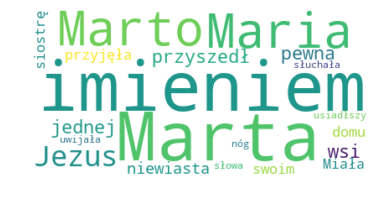

In [28]:
text = clean_text

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords = ps, max_font_size=200, max_words=20, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Term frequency

In [29]:
from nltk.probability import FreqDist

In [30]:
fdist = FreqDist(no_stops)

In [31]:
fdist

FreqDist({'imieniem': 2, 'marta': 2, 'maria': 2, 'marto': 2, 'jezus': 1, 'przyszedł': 1, 'jednej': 1, 'wsi': 1, 'pewna': 1, 'niewiasta': 1, ...})

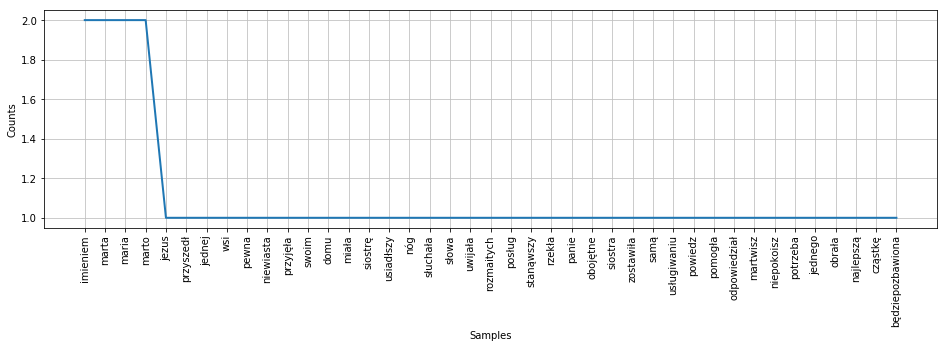

In [32]:
plt.figure(figsize=(16,4))
fdist_plot = fdist.plot()
plt.show()

### Tf-idf 

#### Term frequency - inverse document frequency
Ważenie częstością termów - odwrotna częstość w dokumentach - jedna z metod obliczania wagi słów w oparciu o liczbę ich wystąpień, należąca do grupy algorytmów obliczających statystyczne wagi termów. 
- Każdy dokument reprezentowany jest przez wektor, składający się z wag słów występujących w tym dokumencie. 
- TFIDF informuje o częstości wystąpienia termów uwzględniając jednocześnie odpowiednie wyważenie znaczenia lokalnego termu i jego znaczenia w kontekście pełnej kolekcji dokumentów. 

https://pl.wikipedia.org/wiki/TFIDF